In [121]:
import os
import sys
import datetime
import time
import re
import pandas as pd
from plotnine import ggplot
import matplotlib as mpl
import matplotlib.pyplot as plt
print("Python version= {0}".format(sys.version_info))
print("Pandas version= {0}".format(pd.__version__))
print("Datetime= {0}".format(datetime.datetime.now()))

Python version= sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
Pandas version= 1.1.3
Datetime= 2020-10-18 10:49:27.046048


In [2]:
data_dir = "./data"

,Month,YYYY,ICC,ICE
0,February,1951,67.7,NaN
1,May,1951,60.2,NaN
2,November,1951,63.6,NaN
3,February,1952,66.2,NaN
4,May,1952,70.4,NaN


In [61]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
options = webdriver.ChromeOptions()

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
prefs = {"download.default_directory" : os.path.abspath(data_dir)}
options.add_experimental_option("prefs",prefs)
chromedriver_path = './chromedriver_win32/chromedriver.exe'
options.add_argument("download.default_directory="+os.path.abspath(data_dir))

driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
url = "https://data.sca.isr.umich.edu/data-archive/mine.php"
driver.get(url)
print(options)

In [63]:
# Locate the Sector and create a Select object
select_element = Select(driver.find_element_by_css_selector("select"))
# this will print out strings available for selection on select_element, used in visible text below
select_element.select_by_index(5)

In [65]:
elements = driver.find_elements_by_name("format")
button = None
for e in elements:
    if e.get_property("value") == 'Comma-Separated (CSV)':
        button = e
        break
if not button:
    raise RuntimeError("Error downloading Consumer Sentiment data from {0}".format(url))
    

In [86]:
def get_downloaded_fpath(dir=None, files_before=None, file_ext=".csv",
                   max_wait = 10, verbose=True):
    import time
    done = False
    start_time = datetime.datetime.now()
    while not done:
        files_after = set(os.listdir(dir))
        new_files = files_after.difference(set(files_before))
        print(new_files)
        for fname in new_files:
            if os.path.splitext(fname)[1] == file_ext:
                return (os.path.join(dir, fname))
        cur_time = datetime.datetime.now()
        if (cur_time - start_time).seconds > 10:
            return None
        time.sleep(0.5)
                
                
files_before = set(os.listdir(data_dir))
button.click()
fpath = get_downloaded_fpath(dir=data_dir, files_before=files_before, file_ext=".csv", max_wait=10)
print(fpath)

{'12026ca4-57b9-4bfb-bbbe-3afef2a89d68.tmp'}
{'sca-table5-on-2020-Oct-18.csv'}
./data\sca-table5-on-2020-Oct-18.csv


In [131]:
df = pd.read_csv(fpath, skiprows=1)
df.drop(df.columns[-1], inplace=True, axis=1)
df['Datetime'] = (100*100*df['Year'] + 100*df["Month"] + 15).astype(str)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop(["Month", "Year"],  inplace=True, axis=1)
print(df.agg(['min', 'max']))
df.set_index("Datetime", inplace=True)
df.head()
exp_columns = [c for c in df.columns if re.search("xpected|12 Months", c)]
                                             

     Personal Finance Current  Personal Finance Expected  \
min                        58                         96   
max                       142                        137   

     Business Condition 12 Months  Business Condition 5 Years  \
min                            31                          48   
max                           132                         112   

     Buying Conditions  Current Index  Expected Index   Datetime  
min                 86           57.5            47.6 2008-01-15  
max                173          121.2            93.5 2020-08-15  


(0.0, 142.3)

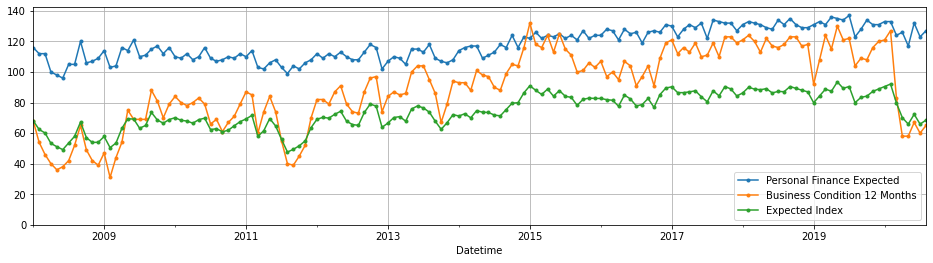

In [127]:
df[exp_columns].plot(figsize=[16,4], marker='.', grid=True)
plt.gca().set_ylim(bottom=0)